<a href="https://colab.research.google.com/github/Hannahhhhhhhhhhhh/Learning-with-d2l/blob/main/Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

28 批量归一化【动手学深度学习v2】:https://www.bilibili.com/video/BV1X44y1r77r?p=2

李宏毅2021机器学习【week4】：批次标准化（BN）简介:
https://www.bilibili.com/video/BV1qh411D72a?spm_id_from=333.337.search-card.all.click

Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
https://arxiv.org/abs/1502.03167

How Does Batch Normalization Help Optimization?
https://arxiv.org/abs/1805.11604

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
  if not torch.is_grad_enabled():
    # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差，即全局保存的均值和方差
    X_hat = (X - moving_mean)/torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2,4) # either FC or Convolution
    if len(X.shape) == 2:
      # 使用全连接层的情况，计算特征维上的均值和方差
      mean = X.mean(dim=0) # 按照行来求平均
      var = ((X-mean)**2).mean(dim=0)
    else:
      # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
      # 这里我们需要保持X的形状以便后面可以做广播运算
      mean = X.mean(dim=(0,2,3), keepdim=True) 
      var = ((X-mean)**2).mean(dim=(0,2,3), keepdim=True) 
    # 训练模式下，用当前的均值和方差做标准化
    X_hat = (X-mean)/torch.sqrt(var+eps)
    # 更新移动平均的均值和方差
    moving_mean = momentum * moving_mean +(1.0-momentum) * mean
    moving_var = momentum * moving_var +(1.0-momentum) * var
  Y = gamma * X_hat + beta # 缩放和移位
  return Y, moving_mean.data, moving_var.data

In [6]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)

    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
    # gamma 和 beta需要更新
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    # moving_mean, moving_var不是学习参数, 非模型参数的变量初始化为0和1
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)
  
  def forward(self, X):
    # 如果X不在内存上，将moving_mean和moving_var
    # 复制到X所在显存上
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
       # 保存更新过的moving_mean和moving_var
    Y, self.moving_mean, self.moving_var = batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var,
        eps=1e-5, momentum=0.9)
    return Y

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

In [8]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

  0%|          | 0/26421880 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

loss 0.266, train acc 0.902, test acc 0.855
10625.2 examples/sec on cuda:0


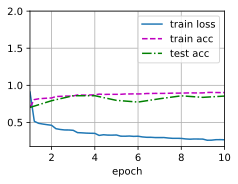

In [9]:
lr, num_epochs, batch_size = 2.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.258, train acc 0.903, test acc 0.868
17964.7 examples/sec on cuda:0


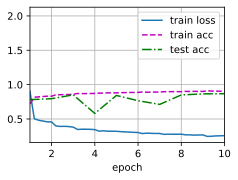

In [10]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [2]:
!pip install d2l

     |████████████████████████████████| 82 kB 590 kB/s 
     |████████████████████████████████| 61 kB 7.2 MB/s 
     |████████████████████████████████| 11.2 MB 31.8 MB/s 
     |████████████████████████████████| 9.9 MB 38.5 MB/s 
     |████████████████████████████████| 15.7 MB 36.8 MB/s 
     |████████████████████████████████| 930 kB 45.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's depende

In [3]:
!pip install matplotlib==3.0

     |████████████████████████████████| 12.8 MB 4.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
